In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import preprocessor as p
import re
from textblob import TextBlob

In [84]:
def get_data(ticker):
    website_url = 'https://finviz.com/quote.ashx?t='
    company_tikcers = [ticker]
    news_tables = {}
    for ticker in company_tikcers:
        url = website_url + ticker
        req = Request(url=url, headers={'user-agent': 'my-scrape'})
        response = urlopen(req)
        html = BeautifulSoup(response, 'html')
        news_data = html.find(id='news-table')
        news_tables[ticker] = news_data
    parsed_data = []

    for ticker, news_table in news_tables.items():
        for row in news_table.findAll('tr'):
            title = row.a.text
            date_data = row.td.text.split(' ')
        
            if len(date_data) == 1:
                time = date_data[0][0:7]
            else:
                date = datetime.datetime.strptime(date_data[0], '%b-%d-%y').strftime('%Y/%m/%d')
                time = date_data[1][0:7]
            parsed_data.append([ticker, date, time, title])
    df = pd.DataFrame(parsed_data, columns=["Company", "Date", "Time", "News Headline"])
    df.to_csv('CompanyNewsHeadlines_WithoutSentiment.csv', index=False)
    return df

In [85]:
def sentiment_analysis(tweets):
    tweet_list = []
    global_polarity = 0
    tw_list=[]
    pos=0
    neg=1
    for tweet in tweets:
        count=20
        tw2 = tweet
        tw = tweet
        tw=p.clean(tw)
        tw=re.sub('&amp;','&',tw)
        tw=re.sub(':','',tw)
        tw=tw.encode('ascii', 'ignore').decode('ascii')
        blob = TextBlob(tw)
        polarity = 0
        for sentence in blob.sentences:

            polarity += sentence.sentiment.polarity
            if polarity>0:
                pos=pos+1
            if polarity<0:
                neg=neg+1

            global_polarity += sentence.sentiment.polarity
        if count > 0:
            tw_list.append(tw2)

        tweet_list.append((tw, polarity))
        count=count-1
    if len(tweet_list) != 0:
        global_polarity = global_polarity / len(tweet_list)
    else:
        global_polarity = global_polarity
    neutral=100-pos-neg
    if neutral<0:
        neg=neg+neutral
        neutral=20
    print()
    print("Positive Tweets :",pos,"Negative Tweets :",neg,"Neutral Tweets :",neutral)
    labels=['Positive','Negative','Neutral']
    sizes = [pos,neg,neutral]
    explode = (0, 0, 0)
    fig = plt.figure(figsize=(7.2,4.8),dpi=65)
    fig1, ax1 = plt.subplots(figsize=(7.2,4.8),dpi=65)
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.tight_layout()
    plt.savefig('SA.png')
    plt.close(fig)
    #plt.show()
    if global_polarity>0:
        print()
        print("Tweets Polarity: Overall Positive")
        tw_pol="Overall Positive"
    else:
        print()
        print("Tweets Polarity: Overall Negative")
        tw_pol="Overall Negative"
    return global_polarity,tw_list,tw_pol,pos,neg,neutral

In [86]:
def recommendation(global_polarity,today_stock,mean, quote):
    if today_stock < mean:
        if global_polarity > 0:
            idea="RISE"
            decision="BUY"
            print()
            print("According to the ML Predictions and Sentiment Analysis of Tweets, a",idea,"in",quote,"stock is expected => ",decision)
        elif global_polarity <= 0:
            idea="FALL"
            decision="SELL"
            print()
            print("According to the ML Predictions and Sentiment Analysis of Tweets, a",idea,"in",quote,"stock is expected => ",decision)
    else:
        idea="FALL"
        decision="SELL"
        print()
        print("According to the ML Predictions and Sentiment Analysis of Tweets, a",idea,"in",quote,"stock is expected => ",decision)
    return idea, decision

In [87]:
df = get_data('AAPL')


Positive Tweets : 35 Negative Tweets : 13 Neutral Tweets : 52

Tweets Polarity: Overall Positive


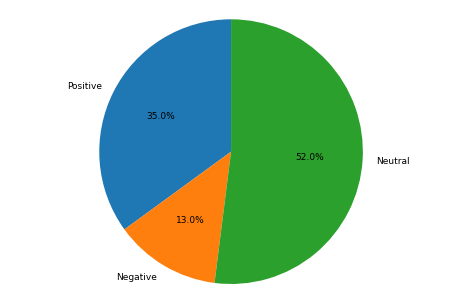

In [88]:
sentiment = sentiment_analysis(df['News Headline'])

In [89]:
recommendation(sentiment[0], 168.43, 155.91, 'AAPL')


According to the ML Predictions and Sentiment Analysis of Tweets, a FALL in AAPL stock is expected =>  SELL


('FALL', 'SELL')